**Exploratory Analysis of Port Clearance Flows**
=================================================
I will try to follow the order in which the quesions are presented in the

"hypothesis document" but in some cases it may get fuzzy as I explore ideas.

This document is essentially work in progress, so it will keep changing.

I'm not saving graphical outputs to disc yet, once JF picks the most

useful plots, I will optimize their look and save them. In some cases

I have saved tabular data to csv but I have also shown the same here.

1. **Day of the week and time of the day distributions**

	This is the first task under further analysis. So far I have 
	
	done exploratory analysis.


******************************************************************

In [145]:
#Useufl Libraries
from IPython.display import display
from tabulate import tabulate
import pandas as pd
# We'll also import seaborn, a Python graphing library
import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
sns.set(style="white", color_codes=True)

**Some Basic Data Processing First**
====================================

In [146]:
#Working folder
data_dir = "../data/"
output_dir = '../outputs/Dunstan'
d_file_v0 = data_dir + "data_v0.csv"

dates = ["T! Ship arrival",
         "T2 Manifest received",
         "T3 Declaration lodged",
         "T4 Declaration validated",
         "T5 Physical inspection",
         "T6 Clearance",
         "T7 Exit"
        ]
d = pd.read_csv(d_file_v0, parse_dates=dates)

In [147]:
#Rename columns
old_names = d.columns
new_names= ['declaration_yr','declaration_num','manifest_yr',
            'manifest_num','ref_ship_service','t1_arrival',
            't2_manifest_recvd','t3_declaration_lodged',
            't4_declaration_validated','t5_inspection',
            't6_clearance','t7_removal']
d.rename(columns=dict(zip(old_names, new_names)), inplace=True)

In [148]:
#Drop cases where the sequence isnt T7>T6>T5>T4>T3>T2>T1
#So basically, if one of the time stamps is missing
len_all = d.shape[0]
d.dropna(axis=0,
         how='any',
         subset=['t1_arrival',
            't2_manifest_recvd','t3_declaration_lodged',
            't4_declaration_validated','t5_inspection',
            't6_clearance','t7_removal'],inplace=True)

print ("%s rows dropped"%(len_all-len(d)))

2506 rows dropped


In [149]:
#Any duplicates on d['declaration_num']
dup_decl = d['declaration_num'].duplicated()
print ("%s duplicates based on number declaration"%(len (dup_decl[dup_decl==True])))

dup_mani = d['manifest_num'].duplicated()
print ("%s duplicates based on number manifest"%(len (dup_mani[dup_mani==True])))

0 duplicates based on number declaration
17351 duplicates based on number manifest


*So what does number manifest really represent?, clearly not unique identifier*

In [6]:
#len (dup[dup==False])
len(d)

17918

**Add variables to represent the three different phases**
=========================================================
1. t1-start of this phase: 't1_arrival'
2. t2-start of this phase:  't3_declaration_lodged'
3. t3-start of this phase: 't7_removal'

In [150]:
#Add the phases
#where t1-upstream phase: t2-clearance phase & t3-removal
d['t1'] = d.t1_arrival
d['t2'] = d.t3_declaration_lodged
d['t3'] = d.t7_removal

**Add date related variables for all time-stamps**
===================================================
1. date
2. month
3. day
4. day of the week
5. hr
6. week dayr or weekend

In [152]:
#Creates a binary variable to see whether this data is a weekday(or holiday) or week/working day
#Hoilday list generated from: http://www.timebie.com/calendar/algeria2016.php
holidays = ['2015-12-24','2015-11-01','2015-10-13','2015-09-25',
           '2015-09-24','2015-06-19','2016-12-12','2016-11-01',
           '2016-10-12','2016-09-14','2016-07-07','2016-07-05',
           '2016-06-19','2016-05-01','2016-01-01']

def week_end(row,column):
    if row[column +"_" + 'wkday_name']=='Friday' or row[column +"_" + 'wkday_name']=='Saturday':
        return 1
    elif row[column +"_"+'date'] in holidays:
        return 1
    else:
        return 0

In [153]:
#For all the time-stamp variables add the date related variables
def add_dates_vars (column, df):
    d[column +"_" + 'yr'] = d.apply(lambda row: row[column].year,axis=1)
    d[column +"_" + 'date'] = d.apply(lambda row: row[column].date().strftime('%Y-%m-%d'),axis=1)
    d[column +"_" + 'month'] = d.apply(lambda row: row[column].month,axis=1)
    d[column +"_" + 'day'] = d.apply(lambda row: row[column].day,axis=1)
    d[column +"_" + 'wkday'] = d.apply(lambda row: row[column].weekday(),axis=1)
    d[column +"_" + 'wkday_name'] = d.apply(lambda row: row[column].weekday_name,axis=1)
    d[column +"_" + 'hr'] = d.apply(lambda row: row[column].hour,axis=1)
    d[column +"_" + 'wkend']= d.apply(lambda row: week_end(row, column), axis=1)

In [154]:
#Now add all the date variables
dates = ['t1_arrival','t2_manifest_recvd','t3_declaration_lodged',
            't4_declaration_validated','t5_inspection',
            't6_clearance','t7_removal', 't1', 't2','t3']
for col in dates:
    #add_dates_vars(col,d)
    add_dates_vars (col, d)

In [156]:
#Add duration variables-use exact time stamps to compute these
#and save as hours
#Note all duration in hours

d['t3_t1'] = d.apply(lambda row: (row['t3_declaration_lodged']-row['t1_arrival']).total_seconds()/3600,axis=1)
d['t6_t3'] = d.apply(lambda row: (row['t6_clearance']-row['t3_declaration_lodged']).total_seconds()/3600,axis=1)
d['t7_t6'] = d.apply(lambda row: (row['t7_removal']-row['t6_clearance']).total_seconds()/3600,axis=1)

#Add othger time steps
d['t6_t5'] = d.apply(lambda row: (row['t6_clearance']-row['t5_inspection']).total_seconds()/3600,axis=1)
d['t5_t4'] = d.apply(lambda row: (row['t5_inspection']-row['t4_declaration_validated']).total_seconds()/3600,axis=1)
d['t4_t3'] = d.apply(lambda row: (row['t4_declaration_validated']-row['t3_declaration_lodged']).total_seconds()/3600,axis=1)
d['t3_t2'] = d.apply(lambda row: (row['t3_declaration_lodged']-row['t2_manifest_recvd']).total_seconds()/3600,axis=1)
d['t2_t1'] = d.apply(lambda row: (row['t3_declaration_lodged']-row['t2_manifest_recvd']).total_seconds()/3600,axis=1)

In [157]:
#Only considering the sequences-Add step with maximum and minimum duration
durations = ['t7_t6','t6_t5','t5_t4','t4_t3','t3_t2','t2_t1' ]
d['max_step_duration'] = d[durations].idxmax(axis=1)
d['min_step_duration'] = d[durations].idxmin(axis=1)

#Also find out which phases takes the longest time-this could be obvious due to the number of steps at phase
d['max_phases'] = d[['t7_t6',"t3_t1",'t6_t3']].idxmax(axis=1)
d['min_phases'] = d[['t7_t6',"t3_t1",'t6_t3']].idxmin(axis=1)

#Also add total duration for each transaction record-based on phases
#d['tot_duration'] = d[['t3_t1','t6_t3','t7_t6']].sum(axis=)

In [158]:
#Function to combine value counts for multiple columns into a single presentable table
def create_table_v1(cols,df_data,new_index):
    i=0
    for c in cols:
        if i==0:
            df = pd.DataFrame(df_data[c].value_counts()).reindex(new_index)
        else:
            df = pd.concat([df, pd.DataFrame(df_data[c].value_counts()).reindex(new_index)],axis=1, join='inner')
        i += 1
    return df

**Which time step takes the most time?**
=========================================
**Which of the three phases takes the most time**
==================================================
This is just to understand quickly at which stage does the shipment spend the most time........

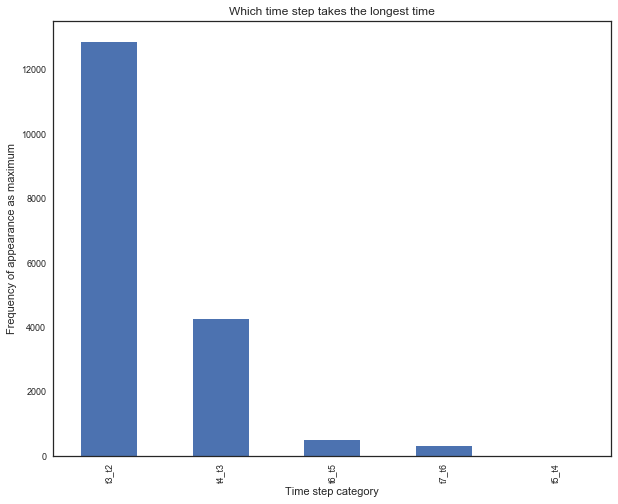

In [160]:
#Lets see a simple chart showing what I described above
ax = d.max_step_duration.value_counts().plot(kind='bar', 
                                        title = 'Which time step takes the longest time',
                                        y='Frequency of appearance as maximum',
                                        x = 'Time steps',
                                        figsize=(10, 8), 
                                        legend=False, 
                                        fontsize=9)

# Set the x-axis label
ax.set_xlabel('Time step category')

# Set the y-axis label
ax.set_ylabel('Frequency of appearance as maximum')

So from barplot above, when we consider all steps,

it seems the step between **manifest received** and **declaration lodged**

took the most time. However, when we consider 

the 3 main phases (in chart below)

The longest time is in the **upstream**

All this could be obvious for those arleady familiar with the process.

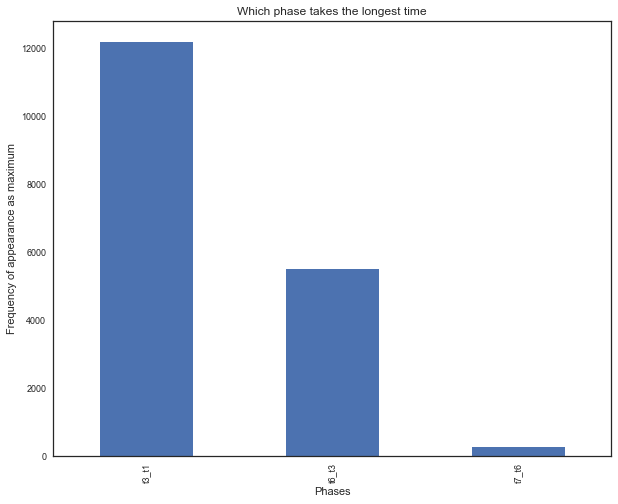

In [161]:
max_phase = create_table_v1(["max_phases"],d, ['t1', 't2','t3'])
#Lets see a simple chart for the table above for maximum duration
ax = d.max_phases.value_counts().plot(kind='bar', 
                                        title = 'Which phase takes the longest time',
                                        y='Frequency of appearance as maximum',
                                        x = 'Time steps',
                                        figsize=(10, 8), 
                                        legend=False, 
                                        fontsize=9)

# Set the x-axis label
ax.set_xlabel('Phases')

# Set the y-axis label
ax.set_ylabel('Frequency of appearance as maximum')

**Compute  basic statistics for the sample**
============================================
In all this, the assumption is that the data is independent and identuically distributed. 
Essentially, arrival of one container doesnt affect the other BUT this could be wrong. For
instance, if containers arrive in a batch, they may choose to process them togather.

1. Container arrivals-just see count of containers by date, day of the week
2. 

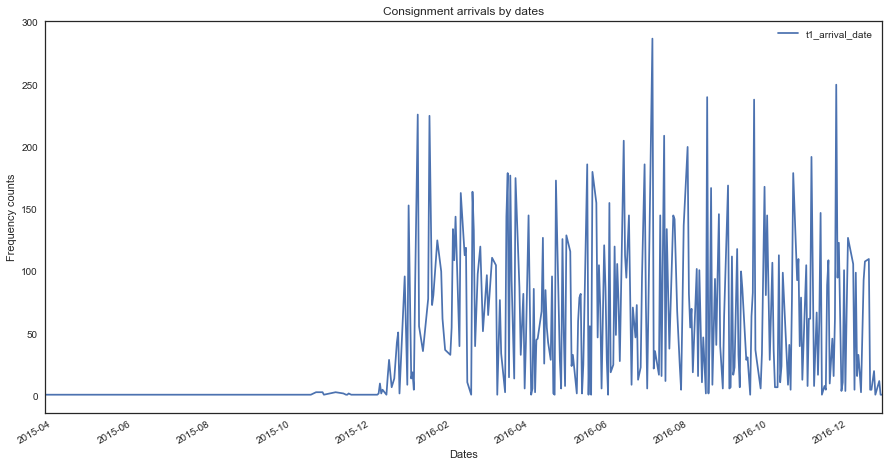

In [163]:
#Check distribution of arrival dates
df_date = pd.DataFrame(d.t1_arrival_date.value_counts())
df_date.index = pd.DatetimeIndex(df_date.index)
ax = df_date.plot(title = 'Consignment arrivals by dates',
                  figsize=(15,8))

# Set the x-axis label
ax.set_xlabel('Dates')

# Set the y-axis label
ax.set_ylabel('Frequency counts')

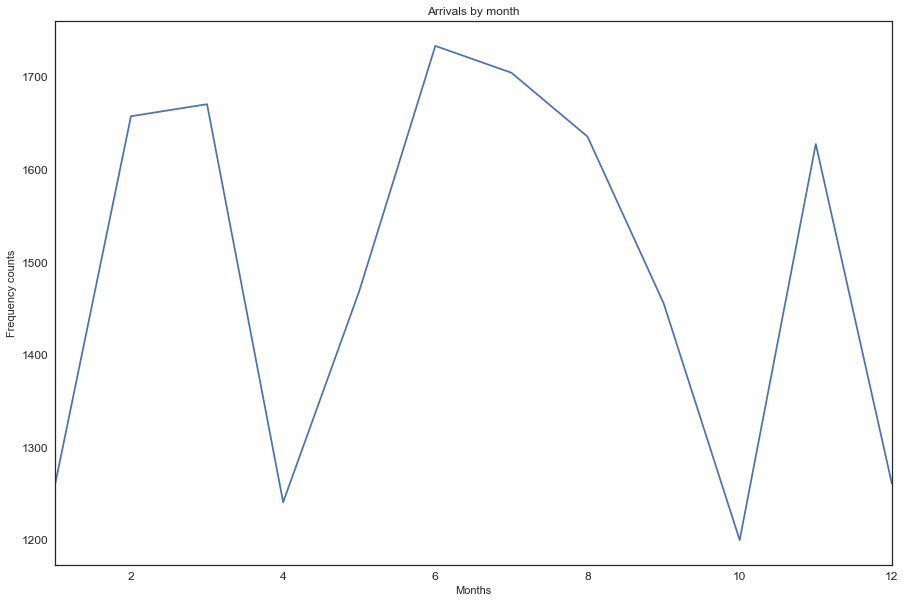

In [164]:
#We can also check arrival time by month
ax = d.t1_arrival_month.value_counts().reindex([i for i in range(1,13)]).plot(kind='line', 
                                        title ="Arrivals by month", 
                                        figsize=(15, 10), 
                                        legend=False, 
                                        fontsize=12)
# Set the x-axis label
ax.set_xlabel('Months')

# Set the y-axis label
ax.set_ylabel('Frequency counts')

From the 2 previous plots above, arrivals seem to be periodic with peaks

in some months, for example, arrivals drop sharply in April and October

probably due to holidays related Ramadan.

**Distribution of Day of the week and time (essentially hour) of the day or each time stamp**
================================================================================================
1. Table showing proportions across each day/hour
2. Barplot
3. Inferring distributions-although this isnt easy for categorical variables

In [165]:
#Function to combine time-stamp columns into a single table for easy comparison
def create_table(cat,df_data,new_index):
    i=0
    for dt in dates:
        if i==0:
            df = pd.DataFrame(df_data[dt + "_" + cat].value_counts()).reindex(new_index) 
        else:
            df = pd.concat([df, pd.DataFrame(df_data[dt + "_" + cat].value_counts()).reindex(new_index)],axis=1, join='inner')
        i += 1
    return df

In [166]:
#Compute and save the Frequencies
output_dir = '../outputs/Dunstan/'
days = create_table('wkday_name', d, ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'])
days = days.drop(['t1_wkday_name', 't2_wkday_name', 't3_wkday_name'], axis=1)
days.columns = [i[:-11] for i in days.columns]

days.to_csv(output_dir + 'wkday_freqs_all_time_steps.csv', index=True,header=True)

hrs = create_table('hr', d, [i for i in range(24)])
hrs = hrs.drop(['t1_hr', 't2_hr', 't3_hr'], axis=1)
hrs.columns = [i[:-3] for i in hrs.columns]
hrs.to_csv(output_dir + 'hr_freqs_all_time_steps.csv', index=True,header=True)

**Some plots for day of the week distribution**
=====================================================
A few things to note from　both the line plot and separate barplots:

1. t1_arrival, t2_manifest_recvd & t3_declaration_lodged seem to have a 
	
	to have a significantly different distribution than the rest of the 
	
	time stamps-this is the upstream phase.

2. From the barplots, distributions from t4-t7 almost identical


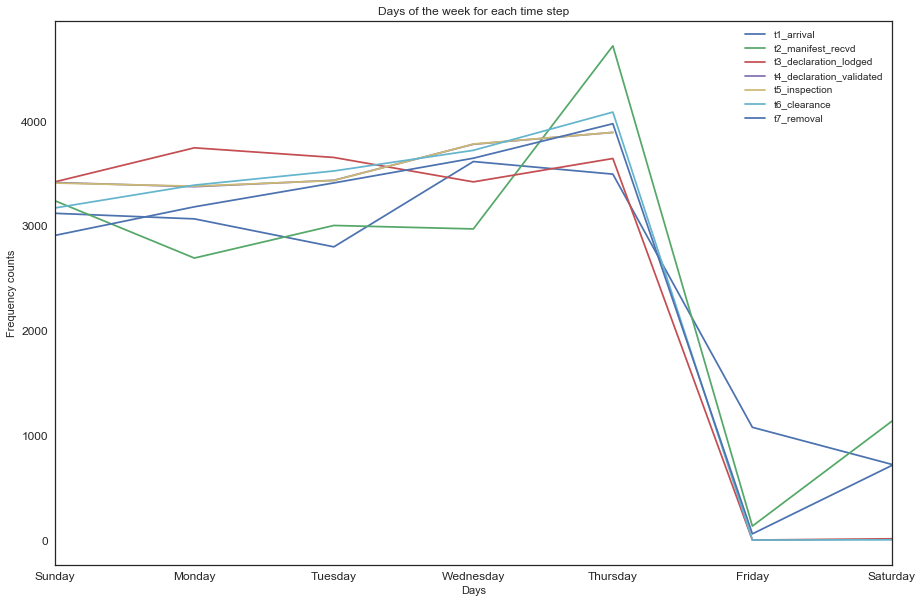

In [170]:
#Day of the week all seen at once
ax = days.plot(title='Days of the week for each time step',
              fontsize=12,
               figsize=(15, 10))

# Set the x-axis label
ax.set_xlabel('Days')

# Set the y-axis label
ax.set_ylabel('Frequency counts')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x130f788d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x119361630>]], dtype=object)

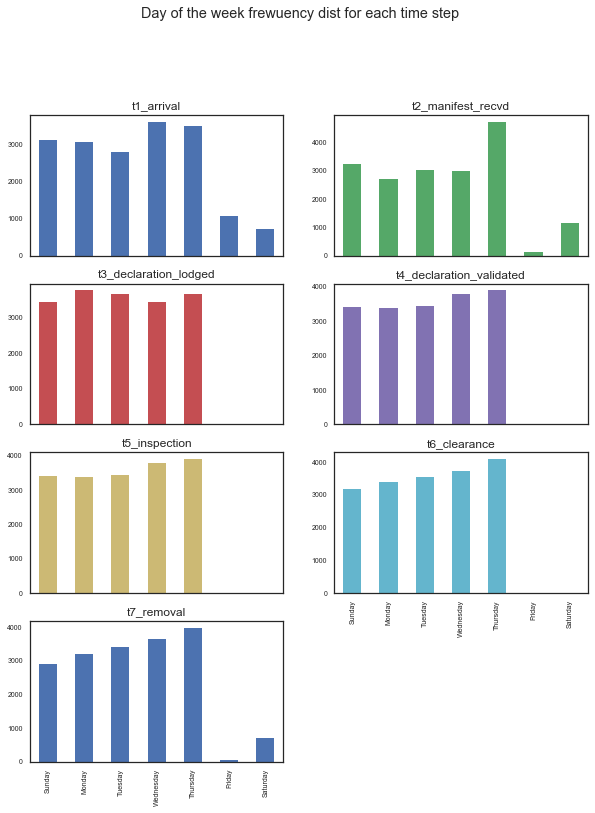

In [171]:
#Barplots for each time stamp by day of the week
days.plot(kind='bar', layout=(5,2),title='Day of the week frewuency dist for each time step',
          figsize=(10, 15),legend=False,
          fontsize=7,
          use_index=True,
          subplots=True)

**We can do the same type of plots for time of the day (here shown by hour)**
==============================================================================

It seems its much easier to see the differences in the barplots

(x-axis is hour of the day) than in the line-plot.  Note the following:
    
1. There seem to be much more variance for hourly dist compared to the daily dist

2. Some of the hourly distributions are clearly multi-modal indicating presence of 
    
    periodicity. For example, take a look at t1_arrival and t2_manifest_recvd.

3. Distribution for t7_removal stage seem to be distinctly different from the rest

    of the time stamps.

*Its worth investigating periodicity further here-if it isnt obvious of course*
    


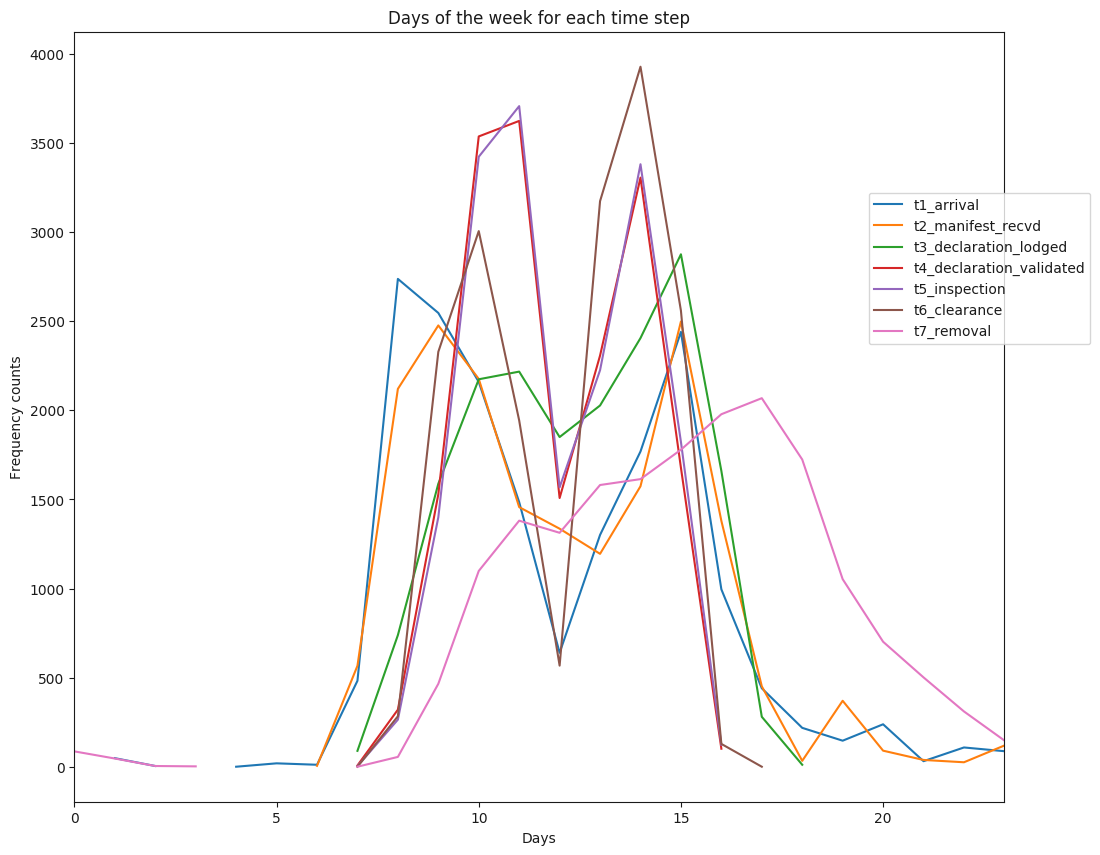

In [142]:
#Day of the week all seen at once
ax = hrs.plot(title='Time of the day for each time step',
             figsize=(12,10))

#put legend somewhere nice
ax.legend (bbox_to_anchor=(1.1, 0.8))

# Set the x-axis label
ax.set_xlabel('Hour')

# Set the y-axis label
ax.set_ylabel('Frequency counts')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x131472be0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1182473c8>]], dtype=object)

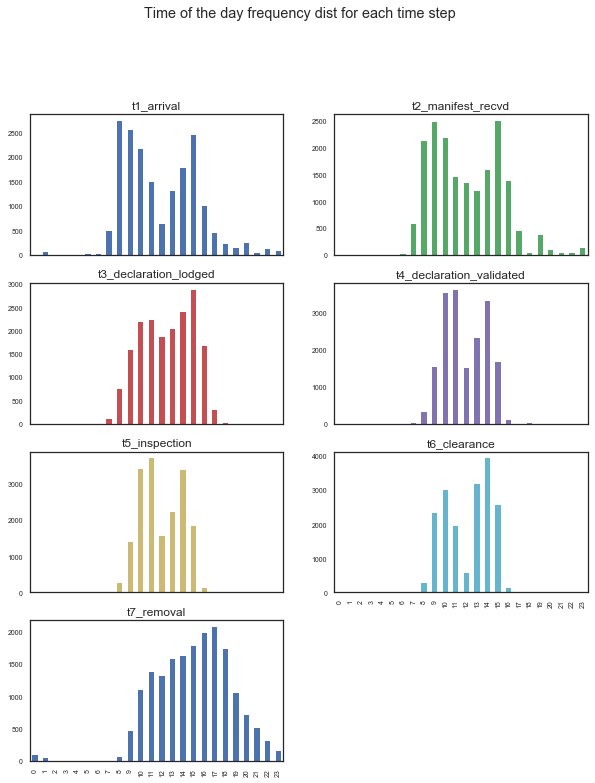

In [172]:
#Barplots for each time stamp by day of the week
hrs.plot(kind='bar', layout=(5,2),title='Time of the day frequency dist for each time step',
          figsize=(10, 15),legend=False,
          fontsize=7,
          use_index=True,
          subplots=True)